# Libs and essential imports

In [12]:
!pip install -q pycm livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [13]:
import torch
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


In [14]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [15]:
cd drive/MyDrive/IRP_ty221/

[Errno 2] No such file or directory: 'drive/MyDrive/IRP_ty221/'
/content


In [24]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ground_vibration.xlsx to ground_vibration.xlsx
User uploaded file "ground_vibration.xlsx" with length 43010 bytes


In [26]:
mkdir "Pics"

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import explained_variance_score
from sklearn import metrics
from sklearn.metrics import mean_absolute_error 
import random
import time


# Data Preprocessing

In [17]:
# Choose data sheet

def LoadDataset(sheet_opt = 2012):
  """
  Load the specific dataset into pandas dataframe

  Parameters
  ----------
  sheet_opt : int (2012 or 2018)
            The option of sheet name, 
            2012 for hudaverdi_2012,
            2018 for lopes_2018

  Returns
  -------
  df_blast_data: pandas.DataFrame
                The raw data of the datasheet
  feature      : pandas.DataFrame
                The feature rows of the dataset
  targets      : pandas.DataFrame
                The target rows of the dataset

  """
  if (sheet_opt == 2012):
    df_blast_data = pd.read_excel('ground_vibration.xlsx', sheet_name='hudaverdi_2012')
    feature = df_blast_data.iloc[1:,1: 9]
    targets = df_blast_data.iloc[1:,-2]
    print("sheet named hudaverdi_2012 has been extracted successfully !")
  elif (sheet_opt == 2018):
    df_blast_data = pd.read_excel('ground_vibration.xlsx', sheet_name='lopes_2018')
    feature = df_blast_data.iloc[:,[14,-2]]
    targets = df_blast_data.iloc[:, [-4]]
    print("sheet named lopes_2018 has been extracted successfully !")
  else:
    print("no such sheet in execl ground_vibration.xlsx")

  return df_blast_data, feature, targets


## Outlier detect

In [18]:
# detect outliers

def DetectOutliers (feature, targets):
  """
  Detect the outliers in the dataset and 
  replace them with the mean of the dataset 
  without outliers

  Parameters
  ----------
  feature: ndarray or pd.DataFrame
      The feature of the dataset
  targets: ndarray or pd.DataFrame
      The targets of the dataset

  Returns
  -------
  new_targets: nd.array
      The new targets which outliers has been
      repleced

  """
  global new_targets
  print("\nOutlier detection process start!\n")
  data_y = np.array(targets).ravel()
  data_x = np.array(feature)

  n = 3 # 3 sigma rule
  ymean = np.mean(data_y) # mean of the targets
  ystd = np.std(data_y) # standard deviation 
  threshold1 = ymean - n * ystd 
  threshold2 = ymean + n * ystd

  outlier = [] # Save the outliers
  outlier_x = [] # Save the position of the outliers
  outlier_index = [] # Save the index

  # Detection start
  for i in range(0, len(data_y)):
      if (data_y[i] < threshold1)|(data_y[i] > threshold2):
          outlier.append(data_y[i])
          outlier_x.append(data_x[i])
          outlier_index.append(i)
      else:
          continue
  # if there are outliers
  if(outlier):
    print("\nOutliers have been detected!\n")
    print('\nThe outliers are\n')
    print(outlier)
    print('\nThe position of outliers are\n')
    for i in range(len(outlier_index)):
      print(outlier_x[0])

    # delete the outliers to calculate the mean
    np_target_without_outlier = np.delete(data_y, outlier_index)
    mean_without_outlier = np_target_without_outlier.mean()

    np_new_targets = np.array(targets).ravel()
    new_targets = pd.DataFrame (np_new_targets, columns = targets.columns)
    # replace the outlier value
    for i in range(len(outlier_index)):
      new_targets[outlier_index[i]] = mean_without_outlier

    return 1

  # if there is no outlier
  else:
    new_targets = targets
    print("\nIn this dataset, there is no outlier!\n")
    return 0

# tool to plot the data scatter
def data_scatter(feature,targets):
    """
    Plot the scatters of the feature and target

    Parameters
    ----------
    feature: ndarray or pd.DataFrame
        The feature dataset
    targets: ndarray or pd.DataFrame
        The targets dataset

    Returns
    -------
    No return as this function directly plot 
    the scatter diagram

    """
    x = feature.iloc[:,0]
    y = feature.iloc[:,1]
    z = np.array(targets).ravel()

    fig3D = plt.figure()
    ax = Axes3D(fig3D)
    ax.scatter(x, y, z)
    ax.set_zlabel('Z', fontdict={'size': 15, 'color': 'red'})
    ax.set_ylabel('Y', fontdict={'size': 15, 'color': 'red'})
    ax.set_xlabel('X', fontdict={'size': 15, 'color': 'red'})
    plt.show()

    plt.show()


## Choose key featuers with RF

In [19]:
# Dimension reduction with random forest

def FeatureSelect(data_fea, data_tar, top_n = 9, n = 9):
  """
  Select the most related features based on the 
  importance calculated by random forest algorithm and 
  return the corresponding index of top related features.
  Also, a histogram will be plotted

  Parameters
  ----------
  data_fea: ndarray or pd.DataFrame
      The total feature rows
  data_tar: ndarray or pd.DataFrame
      The total target rows
  top_n: int
      The number of the most related features 
      that are shown in the plot. Default value is 5
  n    : int
      The number of the most related features
      that are chosen as the feature to return

  Returns
  -------
  top_features_indices: nd.array
      The array of indices of the top features
      chosen to be returned

  """

  print("Random forest feature selection start!")

  global top_features_indices

  if (data_fea.shape[1] >= 2):
    # set the random forset model
    model = RandomForestRegressor(random_state=1, max_depth=10)
    # RF does not accept nan, bool, str, etc as input. Only number can be the input
    data_fea = data_fea.fillna(0) 
    data_fea=pd.get_dummies(data_fea)

    # fit the model
    model.fit(data_fea,data_tar)
    
    # plot the histogram plot according to the importance
    features = data_fea.columns
    importances = model.feature_importances_
    indices = np.argsort(importances[0:top_n])  # choose top most realted feature 
    fig= plt.figure(figsize=(8,8))
    plt.title('Index selection')
    plt.barh(range(len(indices)), importances[indices], color='royalblue', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative importance of indicators')
    fig.savefig("Pics/Importance_hist")
    plt.show()

    # attain the top features that will be returned
    top_features = [features[i] for i in indices[::-1][0:n]]
    print("\nThe top", n, "features are :", top_features)
    top_features_indices = []
    # get the indices
    for i in range(len(top_features)):
      top_features_indices.append(df_blast_data.columns.get_loc(top_features[i]))
    print("\nTheir indices are:", top_features_indices)

    return 1

  else:
    print("There is no need to select!")
    return 0

# RF-PSO-SVM



In [28]:
from sklearn.model_selection import LeaveOneOut, KFold

def Loocv(feature_transformed, new_targets_tmp, C, epsilon, gamma, 
          fit = True, n_splits = 10):
  """
  This function is to calculate the fitness value(R2) and other 
  statisticla indices (MSE and MAE) based on k-fold 
  cross validation

  Parameters
  ----------
  feature_transformed: ndarray or pd.DataFrame
      The features 
  new_targets_tmp.   : ndarray or pd.DataFrame
      The targets
  C                  : float
      The trade off hyperparameter of SVM 
  epsilon            : float 
      The epsilon hyperparameter of SVM 
  gamma              : float
      The gamma hyperparameter of SVM
  fit                : bool (default by True)
      A bool value deciding return 
      R2 or a set of R2, MSE and MAE
  n_splits           : int (default by 10)
      The number of folds in cross validation  
  Returns
  -------
  if (fit == True):
    R2_average: float
        The average R2 value of the validation groups
  else :
    R2_average : The average R2 value of the validation groups
    MSE_average: The average MSE value of the validation groups
    MAE_average: The average MAE value of the validation groups
    R2_list    : The list of R2 values of the validation groups
    MSE_list   : The list of MSE values of the validation groups
    MAE_list   : The list of MAE values of the validation groups
    
  """

  if (fit):
    R2_list = []

    loo = KFold(n_splits)
    for train, test in loo.split(feature_transformed):
      X_train = np.array(feature_transformed[train])
      y_train = np.array(new_targets_tmp)[train]
      X_test =  np.array(feature_transformed[test])
      y_test = np.array(new_targets_tmp)[test]

      model_svr = SVR(kernel='rbf',C=C,epsilon=epsilon ,gamma=gamma)
      model_svr.fit(X_train,y_train)
      predict_results = model_svr.predict(X_test)

      R2_list.append(metrics.r2_score(y_test,predict_results))

    R2_average = np.mean(R2_list)

    return R2_average
  
  else:
    MSE_list = []
    R2_list = []
    MAE_list = []

    loo = KFold(n_splits)
    for train, test in loo.split(feature_transformed):
      X_train = np.array(feature_transformed[train])
      y_train = np.array(new_targets_tmp)[train]
      X_test =  np.array(feature_transformed[test])
      y_test = np.array(new_targets_tmp)[test]

      model_svr = SVR(kernel='rbf',C=C,epsilon=epsilon ,gamma=gamma)
      model_svr.fit(X_train,y_train)
      predict_results = model_svr.predict(X_test)
      MSE_list.append(mean_squared_error(y_test,predict_results))
      R2_list.append(metrics.r2_score(y_test,predict_results))
      MAE_list.append(mean_absolute_error(y_test,predict_results))

    MSE_average = np.mean(MSE_list)
    R2_average = np.mean(R2_list)
    MAE_average = np.mean(MAE_list)
    return  R2_average, MSE_average, MAE_average, R2_list, MSE_list, MAE_list


In [29]:
# PSO
class PSO:

    def __init__(self, parameters, feature_transformed, targets):
        """
        This is the initialization function of PSO class
        particle swarm optimization

        Parameters
        ----------
        parameters: list or list like
                  The parameters of PSO,
                   including number of generations,
                   population size,
                   number of variables,
                   and variables bound

        Return
        ----------
        No return
        """
        # initialization of parameters
        self.num_gen = parameters[0]  # number of generations
        self.pop_size = parameters[1]  # population size of each generation
        # number of variables to be optimized
        self.num_var = len(parameters[2])
        self.bound = []  # limitation of variables to be optimized
        self.bound.append(parameters[2])
        self.bound.append(parameters[3])
        # the positions of all particles
        self.pop_x = np.zeros((self.pop_size, self.num_var))
        # the speeds of all particles
        self.pop_v = np.zeros((self.pop_size, self.num_var))
        # the best position of every particle
        self.p_best = np.zeros((self.pop_size, self.num_var))
        self.g_best = np.zeros((1, self.num_var))  # global optimized position

        self.feature_transformed = feature_transformed
        self.targets = targets
        # initialize the first generation randomly
        temp = -1
        for i in range(self.pop_size):
            for j in range(self.num_var):
                self.pop_x[i][j] = random.uniform(
                    self.bound[0][j], self.bound[1][j])
                self.pop_v[i][j] = random.uniform(0, 1)
            self.p_best[i] = self.pop_x[i]  # store the best individual
            fit = self.fitness(self.p_best[i])
            if fit > temp:
                self.g_best = self.p_best[i]
                temp = fit

    def fitness(self, ind_var):
        """
        This is a method to calculate the fitness value of each particle

        Parameters
        ----------
        ind_var: list or list like
                Storing the variables to be optimized, in this case,
                they are: C, epsilon anf gamma

        Return
        ----------
        fitness_value: float
                      The calulated fitness value, in this case,
                      it can represent R2, MSE or MAE
        """
        # X = feature_train
        # y = target_train
        x1 = ind_var[0]
        x2 = ind_var[1]
        x3 = ind_var[2]

        if x1 == 0:
            x1 = 0.001
        if x2 == 0:
            x2 = 0.001
        if x3 == 0:
            x3 = 0.001

        fitness_value = Loocv(
            self.feature_transformed,
            self.targets,
            C=x1,
            epsilon=x2,
            gamma=x3)
        return fitness_value

    def update_operator(self, pop_size, gen):
        """
        Update operator to update the speed and position of next moment

        Parameters
        ----------
        pop_size: int
                 The size of the population
        gen     : int
                 The currrent number of generation

        Return
        ----------
        No return as it will directly update the attributes of the object
        """
        
        t = gen
        n = self.num_gen
        w = (0.4 / n ** 2) * (t - n) ** 2 + 0.4
        c1 = -3 * t / n + 3.5
        c2 = 3 * t / n + 0.5

        for i in range(pop_size):
            # Update velocity vector
            self.pop_v[i] = w * self.pop_v[i] + c1 * random.uniform(0, 1) * (
                self.p_best[i] - self.pop_x[i]) + c2 * random.uniform(0, 1) * (
                self.g_best - self.pop_x[i])
            # Update locations
            self.pop_x[i] = self.pop_x[i] + self.pop_v[i]
            # out-of-bounds protection
            for j in range(self.num_var):
                if self.pop_x[i][j] < self.bound[0][j]:
                    self.pop_x[i][j] = self.bound[0][j]
                if self.pop_x[i][j] > self.bound[1][j]:
                    self.pop_x[i][j] = self.bound[1][j]

            # Update p_best (local best) and g_best (global best)
            if self.fitness(self.pop_x[i]) > self.fitness(self.p_best[i]):
                self.p_best[i] = self.pop_x[i]
            if self.fitness(self.pop_x[i]) > self.fitness(self.g_best):
                self.g_best = self.pop_x[i]

    def main(self):
        """
        Optimization process calling the methods to conduct PSO

        Parameters
        ----------
        No parameters

        Return
        ----------
        ng_best : list
                The list of the optimal position,
                which is the optimized hyperparameters of the model
        """
        print("\n PSO optimization process start! \n")

        popobj = []  # store the fitness value evolution
        self.ng_best = np.zeros((1, self.num_var))[
            0]  # initialize the global best
        for gen in range(self.num_gen):

            # draw 4D plot
            if (gen == 0 or gen == 10 or gen == 20 or gen == (self.num_gen - 1)):
                x_list = []
                y_list = []
                z_list = []
                c_list = []

                for p in range(self.pop_size):
                    # record the locations of particles in the population
                    x_list.append(self.pop_x[p][0])
                    y_list.append(self.pop_x[p][1])
                    z_list.append(self.pop_x[p][2])

                    c_list.append(self.fitness(self.pop_x[p]))

                fig = plt.figure(figsize=(9, 10.5))
                ax1 = fig.add_subplot(211, projection='3d')
                ax2 = fig.add_subplot(212)

                img1 = ax1.scatter(
                    x_list, y_list, z_list, c=c_list, cmap='winter')
                ax1.set_xlabel("C", fontsize=15)
                ax1.set_ylabel("epsilon: \u03B5", fontsize=15)
                ax1.set_zlabel("gamma: \u03B3", fontsize=15)
                ax1.tick_params(axis='x', labelsize=8)
                ax1.tick_params(axis='y', labelsize=8)
                ax1.tick_params(axis='z', labelsize=8)
                fig.colorbar(img1, ax=ax1)

                img2 = ax2.scatter(x_list, y_list, c=c_list, cmap='winter')
                ax2.yaxis.set_ticks_position('right')
                ax2.tick_params(axis='x', labelsize=8)
                ax2.tick_params(axis='y', labelsize=8)
                ax2.set_xlabel("C", fontsize=15)
                ax2.set_ylabel("epsilon: \u03B5", fontsize=15)
                ax2.grid()
                fig.colorbar(img2, ax=ax2)

                fig.savefig(
                    '../Pics/Particle_Distribution_' +
                    str(gen) +
                    'gen.png')
                plt.show()
                # draw end

            self.update_operator(self.pop_size, gen)  # Update
            popobj.append(self.fitness(self.g_best))
            print('---------- Generation {} ----------'.format(str(gen + 1)))
            if self.fitness(self.g_best) > self.fitness(self.ng_best):
                self.ng_best = self.g_best.copy()  # Attain the global best
            print('Best position：{}'.format(self.ng_best))
        print('Highest fitness value：{}'.format(self.fitness(self.ng_best)))
        print("---- End of (successful) Searching ----")

        # Plot the convergence plot
        plt.figure()
        fig = plt.gcf()
        fig.set_size_inches(36, 20)
        plt.xlabel("Iterations", size=30)
        plt.ylabel("Fitness", size=30)
        plt.yticks(size=23)
        plt.xticks(size=23)
        t = [t for t in range(self.num_gen)]
        plt.plot(
            t,
            popobj,
            c='royalblue',
            linewidth=6,
            label='fitness value (R2)')
        plt.grid()
        fig.savefig('../Pics/Convergence_Plot')
        plt.show()
        ng_best = self.ng_best

        return ng_best

In [30]:
def NonLinearModel(feature_transformed, targets, PSO_opt = True):
    """
    NonLinearModel function to firstly randomly set a SVR model then apply 
    PSO to optimize the hyperparameters. It will generate plots for the 
    comparison of performance of the SVR model before and after optimization

    Parameters
    ----------
    feature_transformed: ndarray
                        The normalized feature of the dataset
    
    targets            : ndarray
                        The targets without detected outliers 
    Return
    ----------
    No return but will plot diagrams to compare the performance
    """
    print("\nTrain SVR momdel\n")


    print("The R2 of a randomly initialized SVM: ",Loocv(feature_transformed, targets, C=1,epsilon=0.2,gamma=5))

    if(PSO_opt):
      NGEN = 60
      popsize = 30
      low = [0.001,0.001,0.01]
      up = [1000,1000,8]
      parameters = [NGEN, popsize, low, up]

      pso = PSO(parameters)
      best_hyper_para = pso.main()
      print(best_hyper_para)
      print("---------------------")
      print("The performance of the optimized SVR model is:")
      R2_optimal = Loocv(feature_transformed, targets, C=best_hyper_para[0],epsilon=best_hyper_para[1] ,gamma=best_hyper_para[2])
      print("R2:", Loocv(feature_transformed, targets, C=best_hyper_para[0],epsilon=best_hyper_para[1] ,gamma=best_hyper_para[2]))
      
    return R2_optimal
    


# RUN MODEL 


Begin to Load Data!

sheet named hudaverdi_2012 has been extracted successfully !

Data preprocessing start!


Outlier detection process start!


In this dataset, there is no outlier!

1     22.1
2     32.1
3      5.1
4     13.2
5     11.6
      ... 
84    10.6
85    11.3
86    7.11
87     8.3
88     9.9
Name: Y1, Length: 88, dtype: object
The dataset stays unchanged!
Random forest feature selection start!


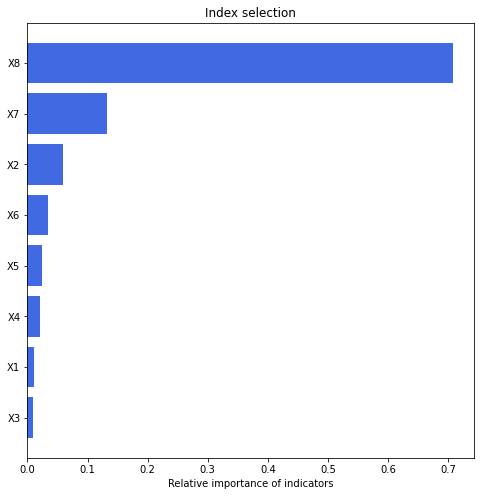


The top 5 features are : ['X8', 'X7', 'X2', 'X6', 'X5']

Their indices are: [8, 7, 2, 6, 5]
The feature has been updated!

Data normalization start!


Data has been normalized!


Train SVR momdel

The R2 of a randomly initialized SVM:  0.30617346006818835

 PSO optimization process start! 



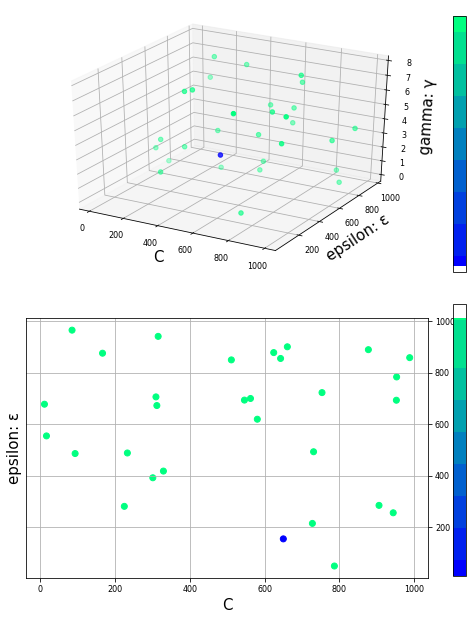

------------ Generation 1 ------------
Best position：[0. 0. 0.]
------------ Generation 2 ------------
Best position：[0. 0. 0.]
------------ Generation 3 ------------
Best position：[8.13053273e+02 1.00000000e-03 8.00000000e+00]
------------ Generation 4 ------------
Best position：[8.13053273e+02 1.00000000e-03 8.00000000e+00]
------------ Generation 5 ------------
Best position：[8.13053273e+02 1.00000000e-03 8.00000000e+00]
------------ Generation 6 ------------
Best position：[8.13053273e+02 1.00000000e-03 8.00000000e+00]
------------ Generation 7 ------------
Best position：[2.01801371e+02 1.00000000e-03 4.73017992e+00]
------------ Generation 8 ------------
Best position：[8.58715293e+01 1.00000000e-03 4.81904892e+00]
------------ Generation 9 ------------
Best position：[6.28849107e+01 1.00000000e-03 4.79194489e+00]
------------ Generation 10 ------------
Best position：[6.28849107e+01 1.00000000e-03 4.79194489e+00]


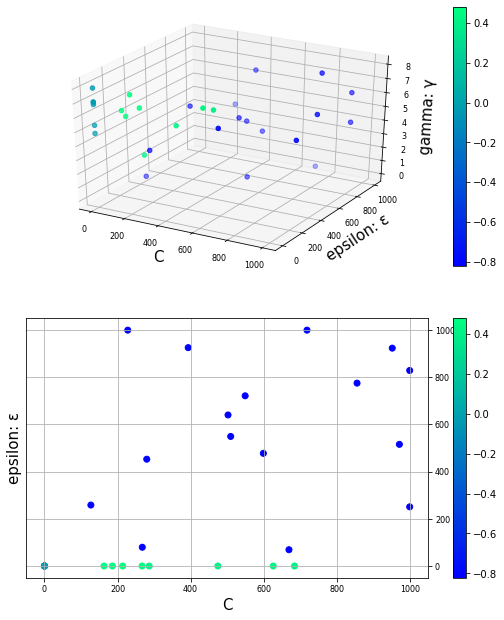

------------ Generation 11 ------------
Best position：[2.60513033e+01 1.00000000e-03 6.50321262e+00]
------------ Generation 12 ------------
Best position：[1.75150355e+01 1.00000000e-03 6.01402413e+00]
------------ Generation 13 ------------
Best position：[2.58646748e+01 1.00000000e-03 5.89001519e+00]
------------ Generation 14 ------------
Best position：[2.58646748e+01 1.00000000e-03 5.89001519e+00]
------------ Generation 15 ------------
Best position：[4.71385367e+00 1.00000000e-03 1.99248677e+00]
------------ Generation 16 ------------
Best position：[7.65938722e+00 1.00000000e-03 6.72931269e-01]
------------ Generation 17 ------------
Best position：[2.25271444e+01 1.00000000e-03 1.09795152e+00]
------------ Generation 18 ------------
Best position：[2.25271444e+01 1.00000000e-03 1.09795152e+00]
------------ Generation 19 ------------
Best position：[3.69521576e+01 1.00000000e-03 6.27318920e-01]
------------ Generation 20 ------------
Best position：[3.69521576e+01 1.00000000e-03 6.2731

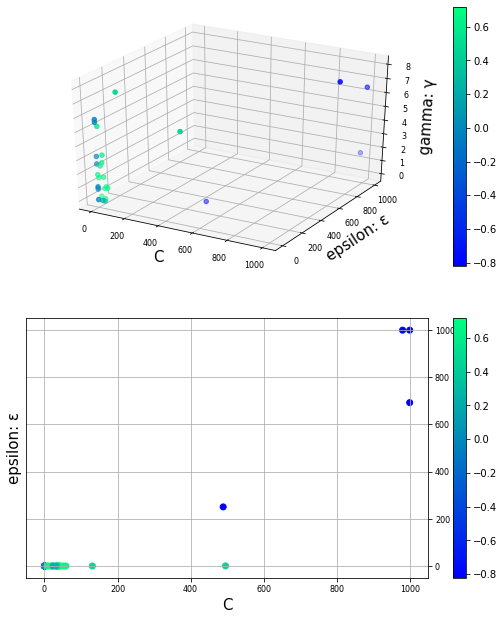

------------ Generation 21 ------------
Best position：[2.78723002e+01 1.00000000e-03 5.15215483e-01]
------------ Generation 22 ------------
Best position：[2.76239916e+01 1.00000000e-03 5.08632676e-01]
------------ Generation 23 ------------
Best position：[2.76239916e+01 1.00000000e-03 5.08632676e-01]
------------ Generation 24 ------------
Best position：[2.76239916e+01 1.00000000e-03 5.08632676e-01]
------------ Generation 25 ------------
Best position：[5.17558626e+01 1.00000000e-03 2.70916117e-01]
------------ Generation 26 ------------
Best position：[6.36991317e+01 1.00000000e-03 2.96751927e-01]
------------ Generation 27 ------------
Best position：[6.36991317e+01 1.00000000e-03 2.96751927e-01]
------------ Generation 28 ------------
Best position：[7.70712719e+01 1.00000000e-03 2.41666044e-01]
------------ Generation 29 ------------
Best position：[7.70712719e+01 1.00000000e-03 2.41666044e-01]
------------ Generation 30 ------------
Best position：[7.85055498e+01 1.00000000e-03 2.3965

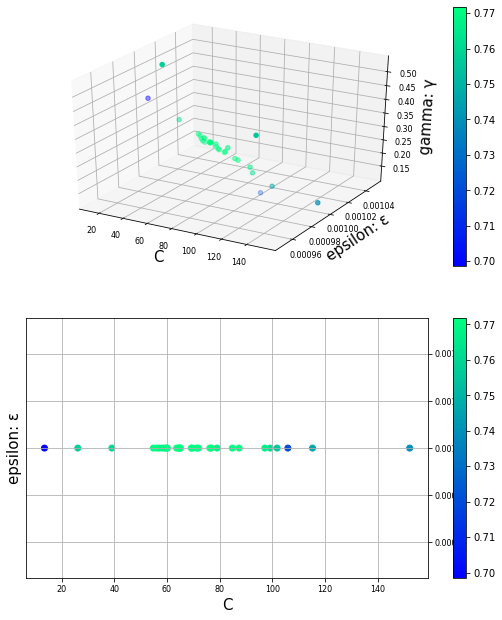

------------ Generation 60 ------------
Best position：[7.25740415e+01 1.00000000e-03 2.56642376e-01]
Highest fitness value：0.7718588535112457
---- End of (successful) Searching ----


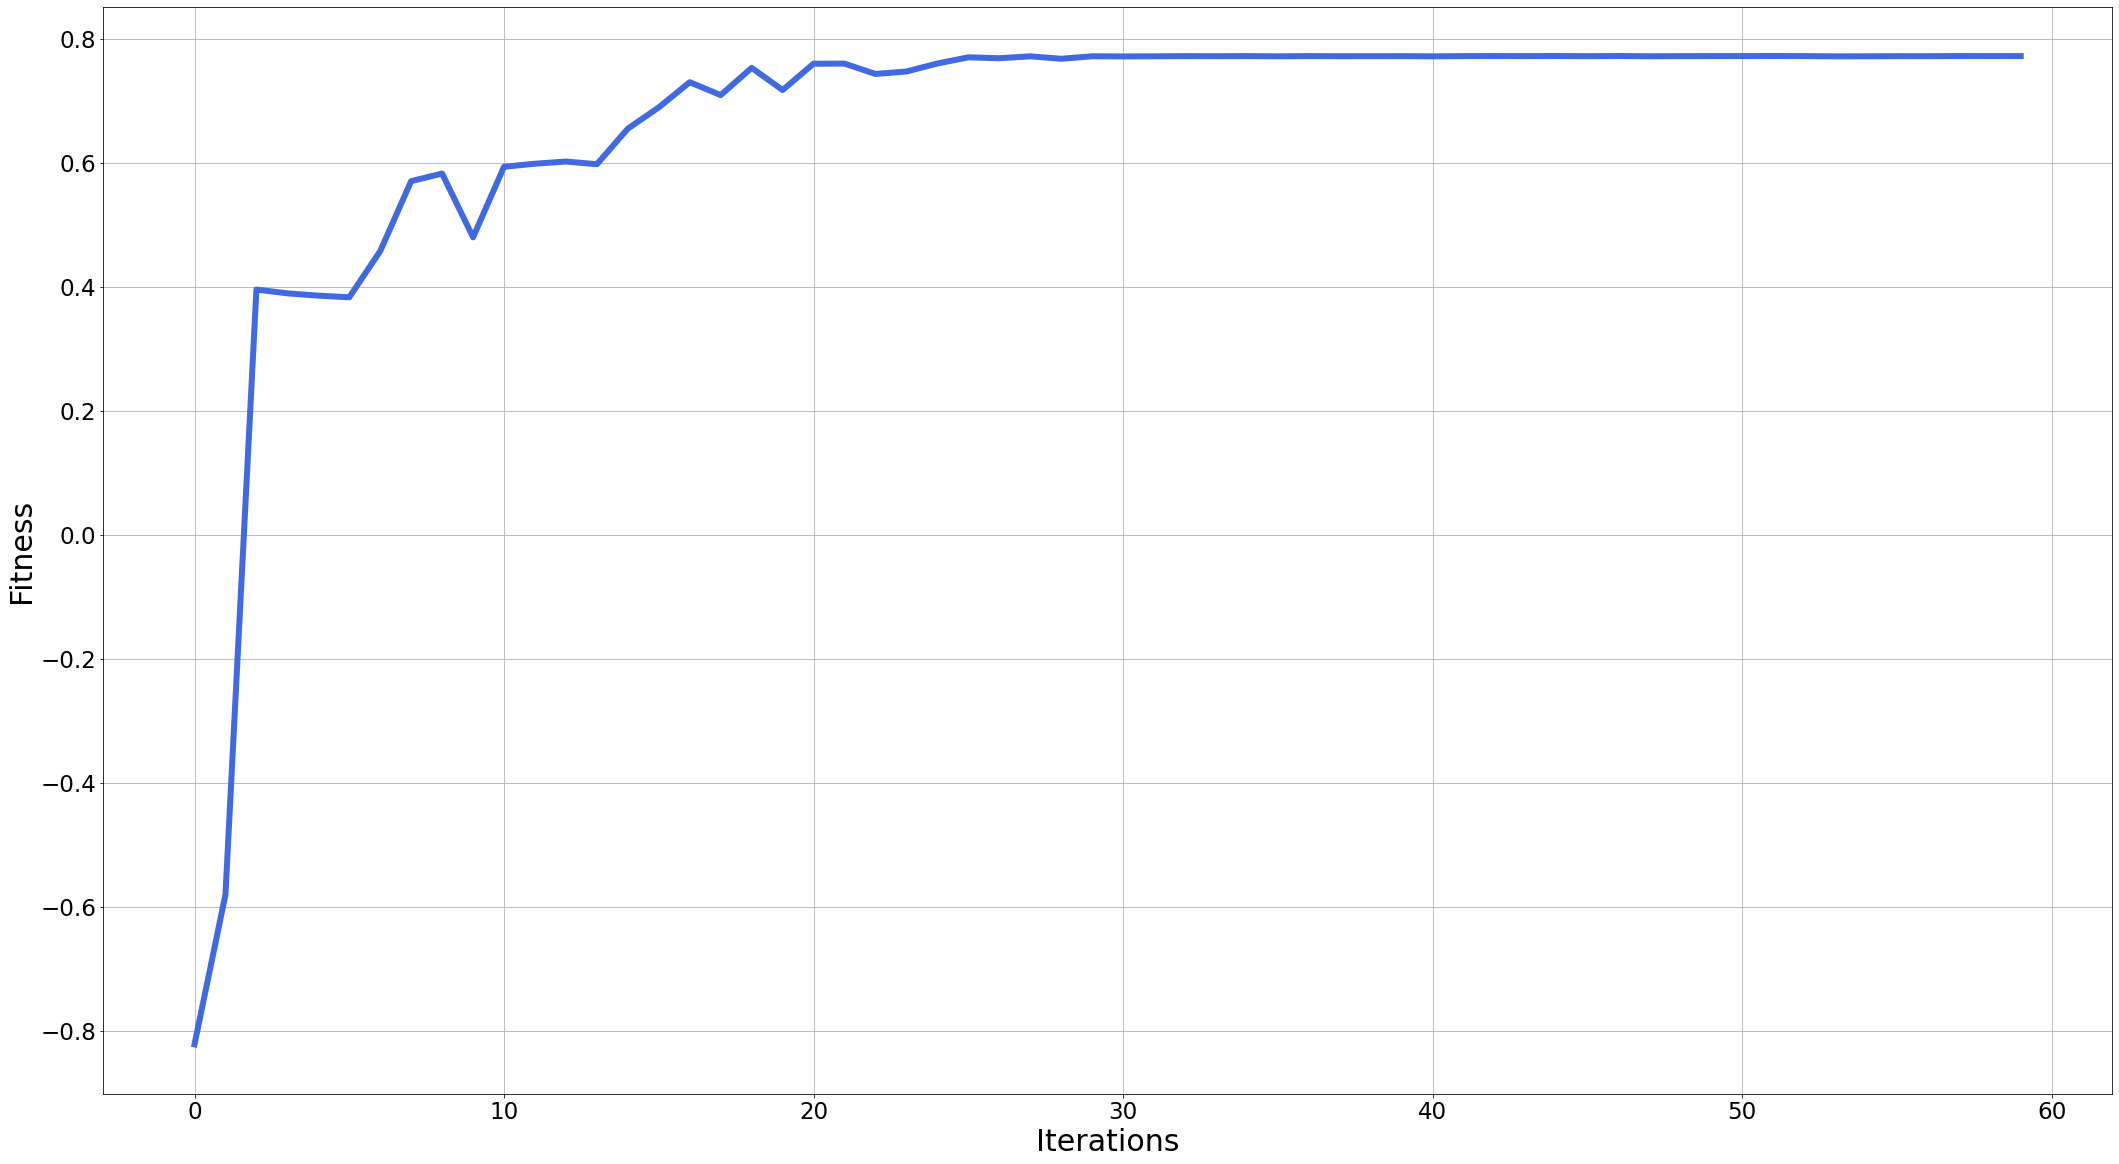

[7.25740415e+01 1.00000000e-03 2.56642376e-01]
---------------------
The performance of the optimized SVR model is:
R2: 0.7718588535112457
time cost 125.57566714286804 s


In [32]:
if __name__ == '__main__':

  sheet_name = 2012
  print("\nBegin to Load Data!\n")
  df_blast_data, feature, targets = LoadDataset(sheet_name)

  print("\nData preprocessing start!\n")
 
  # outlier detection
  targets_no_outliers_IO = DetectOutliers(feature,targets)
  if(targets_no_outliers_IO):
    print("\n")
    print("\nBefore outlier process :")
    data_scatter(feature, targets)
    print("\nAfter outlier process :")
    data_scatter(feature, new_targets)
    targets = new_targets
    print("The targets has been updated!")
  else:
    targets = new_targets
    print(targets)
    print("The dataset stays unchanged!")
  
  # feature selection
  if(sheet_name == 2012):
    data_fea = df_blast_data.iloc[1:,1: 9]  
    data_tar = df_blast_data.iloc[1:,-2]
  elif(sheet_name == 2018):
    data_fea = df_blast_data.iloc[:,[14,-2]]
    data_tar = df_blast_data.iloc[:, [-4]]

  feature_indices_IO = FeatureSelect(data_fea,data_tar, n = 5)
  if (feature_indices_IO):
    new_feature = df_blast_data.iloc[1:,top_features_indices]
    feature = new_feature
    print("The feature has been updated!")
  else:
    print("The feature stay unchangded!")
  
  print("\nData normalization start!\n")
  scaler = MinMaxScaler() 
  # train standardized object
  scaler.fit(feature)
  # transform dataset
  feature_transformed= scaler.transform(feature)
  print("\nData has been normalized!\n")
  
  time_start=time.time()
  NLM_predict_results = NonLinearModel(feature_transformed, targets, PSO_opt = True)
  time_end=time.time()
  print('time cost',time_end-time_start,'s')


In [33]:
R2_average, MSE_average, MAE_average, R2_list, MSE_list, MAE_list = Loocv(feature_transformed, targets, C=71.6475784,epsilon=0.001 ,gamma=0.2590461599,fit = False)
print("R2:", R2_average)
print("MSE = ",MSE_average) 
print("MAE = ",MAE_average) 

R2: 0.7718661829311197
MSE =  13.596632934888202
MAE =  2.755374434843426


In [34]:
SVR_best_predict_results, SVR_best_targets_test, SVR_best_feature_test, SVR_best_target_train, SVR_best_feature_train = SVR_best_ind_cv(feature_transformed,targets,C=268.277249,epsilon=0.001 ,gamma=0.140431318 )


# Data Distribution

In [35]:
def data_distribution(df_blast_data):

  """
  Plot the scatter diagram of the blast data

  Parameters
  ----------
  df_blast_data : pd.DataFrame
      The whole raw data of the dataset

  Returns
  -------
  No returns as it directly save the figure

  """
  blast_data = df_blast_data.iloc[1:, 1:11]
  scatter_matrix = pd.plotting.scatter_matrix(blast_data.convert_dtypes('float') ,figsize=(15,15),
                  c = 'royalblue',
                  marker = 'o',
                  diagonal='hist',
                  hist_kwds={'bins':50,'edgecolor':'limegreen'},
                  alpha = 0.8,
                  range_padding=0.1,
                  )


  for subaxis in scatter_matrix:
      for ax in subaxis:
          ax.xaxis.set_ticks([])
          ax.yaxis.set_ticks([])
          ax.set_xlabel(ax.get_xlabel(), fontsize = 20, rotation = 0)
          ax.set_ylabel(ax.get_ylabel(), fontsize = 20, rotation = 90)

  pic = scatter_matrix[0][0].get_figure()
  pic.savefig("Pics/Data_Distribution")

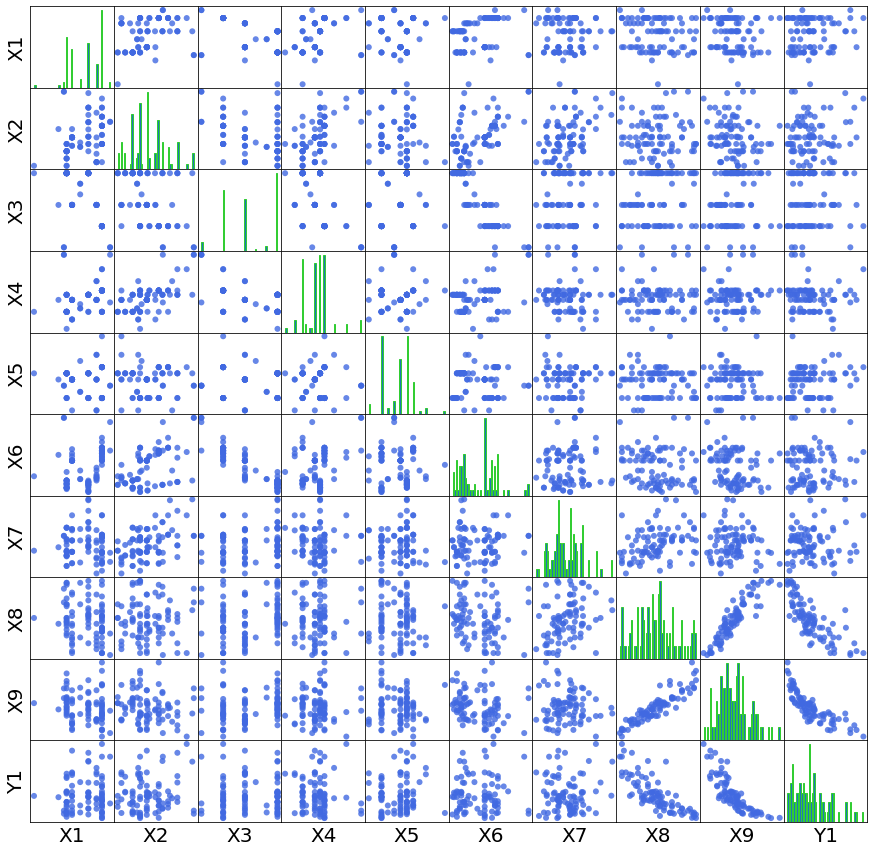

In [36]:
data_distribution(df_blast_data)

# Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
def Grid_search(feature_transformed, targets):
  """
  Conduct the grid search process for SVM

  Parameters
  ----------
  feature_transformed: pandas.DataFrame
                      The features
  targets            : pandas.DataFrame
                      The targets

  Returns
  -------
  No returns as it directly save a set of figures

  """

  C_list = np.arange (0.001, 1000, 10)
  epsilon_list = np.arange (0.001, 1000, 10)
  gamma_list = np.arange (0.001, 8, 1)

  param = {'C' : C_list ,'epsilon' : epsilon_list,'gamma' : gamma_list}

  modelsvr = SVR(kernel = 'rbf')

  grids = GridSearchCV(modelsvr,param,cv=10,scoring='r2')

  time_start=time.time()
  grids.fit(feature_transformed,targets)
  time_end = time.time()
  print(grids.best_params_)
  R2_average, MSE_average, MAE_average, R2_list, MSE_list, MAE_list = Loocv(feature_transformed, targets, C=71.6475784,epsilon=0.001 ,gamma=0.2590461599,fit = False)
  print("R2:", R2_average)
  print("MSE = ",MSE_average) 
  print("MAE = ",MAE_average)   

In [ ]:
  GS_R2_average, GS_MSE_average, GS_MAE_average, GS_R2_list, GS_MSE_list, GS_MAE_list = Loocv(feature_transformed, targets, C=grids.best_params_['C'],epsilon=grids.best_params_['epsilon'] ,gamma=grids.best_params_['gamma'],fit = False)
  
  print("R2:", GS_R2_average)
  print("MSE = ",GS_MSE_average) 
  print("MAE = ",GS_MAE_average) 

R2: 0.7393569969673958
MSE =  15.917698220269434
MAE =  2.979059550305627


# Different Inuputs 

In [37]:
def variance_different_inputs(df_blast_data):

  """
  This function is to record and plot 
  the variance of the PSO-SVM model with different 
  input dimensions.

  Parameters
  ----------
  df_blast_data : The whole raw data from the dataset

  Returns
  -------
  No returns as it directly save the fig

  """

  R2_feature = []
  num_feature = []

  for i in range(9,1,-1):

    FeatureSelect(data_fea, data_tar, n = i)
    new_feature = df_blast_data.iloc[1:,top_features_indices]
    feature = new_feature
    scaler = MinMaxScaler() 
    # train standardized object
    scaler.fit(feature)
    # transform dataset
    t_feature_transformed= scaler.transform(feature)

    NLM_predict_results = NonLinearModel(t_feature_transformed, targets, PSO_opt = True)
    R2_feature.append(NLM_predict_results)
    num_feature.append(i)

  fig = plt.figure(figsize=(9, 10.5))
  num_feature = np.array(num_feature)
  num_feature = num_feature - 1
  plt.plot(num_feature,R2_feature, c = 'royalblue', marker = 'o')
  plt.xlabel("Input dimensions ", size=14)
  plt.ylabel("Fitness value (R2)", size=14)
  plt.grid()
  fig.savefig("Pics/Different_inputs")
  plt.show()


In [ ]:
variance_different_inputs(df_blast_data)

Output hidden; open in https://colab.research.google.com to view.

# Empirical Model



In [39]:
# empirical model evaluation
em_blast_data, em_feature, em_target = LoadDataset(sheet_opt = 2012)

D = np.array(em_blast_data.iloc[1:, 8]).ravel()
Q = np.array(em_blast_data.iloc[1:, 7]).ravel()
real_PPV = np.array(em_blast_data.iloc[1:, 10]).ravel()

y_EM1 = 248.370 * np.power(D/np.power(Q,0.5),-1.207)
y_EM2 = 676.242 * np.power(D/np.power(Q,0.33),-1.215)
y_EM3 = 1.911 * np.power(Q/np.power(D,2/3),1.219)

print("\n")
print("The R2 for Empirical model one is:",metrics.r2_score(real_PPV,y_EM1))
print("The MSE for Empirical model one is:",mean_squared_error(real_PPV,y_EM1))
print("The MAE for Empirical model one is:",mean_absolute_error(real_PPV,y_EM1))
print("\n")
print("The R2 for Empirical model two is:",metrics.r2_score(real_PPV,y_EM2))
print("The MSE for Empirical model two is:",mean_squared_error(real_PPV,y_EM2))
print("The MAE for Empirical model two is:",mean_absolute_error(real_PPV,y_EM2))
print("\n")
print("The R2 for Empirical model three is:",metrics.r2_score(real_PPV,y_EM3))
print("The MSE for Empirical model three is:",mean_squared_error(real_PPV,y_EM3))
print("The MAE for Empirical model three is:",mean_absolute_error(real_PPV,y_EM3))
print("\n")



sheet named hudaverdi_2012 has been extracted successfully !


The R2 for Empirical model one is: 0.7110542376030553
The MSE for Empirical model one is: 18.104755188751493
The MAE for Empirical model one is: 3.368547596879169


The R2 for Empirical model two is: 0.7052907996188986
The MSE for Empirical model two is: 18.46588051858195
The MAE for Empirical model two is: 3.3181111701917634


The R2 for Empirical model three is: 0.46341325627833063
The MSE for Empirical model three is: 33.621436604646625
The MAE for Empirical model three is: 4.579333651439703




In [40]:
def EMs_cv (feature_transformed, targets):
  """
  This function is to attain the statisitical 
  indicatos of empirical models

  Parameters
  ----------
  feature_transformed: pandas.DataFrame
                      The features
  targets            : pandas.DataFrame
                      The targets

  Returns
  -------
  EMs_results: 2d array
              The indicators (R2, MSE, MAE) of three models
  EMs_array  : 2d array
              The arraies of three models recorded during 
              cross validation
  """

  em_blast_data = df_blast_data
  # distance
  D = np.array(em_blast_data.iloc[1:, 8]).ravel() 
  # maximum charge per delay
  Q = np.array(em_blast_data.iloc[1:, 7]).ravel()
  # measured value
  real_PPV = np.array(em_blast_data.iloc[1:, 10]).ravel()

  EM1_MSE_list = []
  EM1_R2_list = []
  EM1_MAE_list = []

  EM2_MSE_list = []
  EM2_R2_list = []
  EM2_MAE_list = []

  EM3_MSE_list = []
  EM3_R2_list = []
  EM3_MAE_list = []

  loo = KFold(n_splits=10)
  for train, test in loo.split(feature_transformed):

    D_cv = D[test]
    Q_cv = Q[test]
    real_PPV_cv = real_PPV[test]
    
    EM1_predict_results = 248.370 * np.power(D_cv/np.power(Q_cv,0.5),-1.207)
    EM2_predict_results = 676.242 * np.power(D_cv/np.power(Q_cv,0.33),-1.215)
    EM3_predict_results = 1.911 * np.power(Q_cv/np.power(D_cv,2/3),1.219)


    EM1_MSE_list.append(mean_squared_error(real_PPV_cv,EM1_predict_results))
    EM1_R2_list.append(metrics.r2_score(real_PPV_cv,EM1_predict_results))
    EM1_MAE_list.append(mean_absolute_error(real_PPV_cv,EM1_predict_results))

    EM2_MSE_list.append(mean_squared_error(real_PPV_cv,EM2_predict_results))
    EM2_R2_list.append(metrics.r2_score(real_PPV_cv,EM2_predict_results))
    EM2_MAE_list.append(mean_absolute_error(real_PPV_cv,EM2_predict_results))

    EM3_MSE_list.append(mean_squared_error(real_PPV_cv,EM3_predict_results))
    EM3_R2_list.append(metrics.r2_score(real_PPV_cv,EM3_predict_results))
    EM3_MAE_list.append(mean_absolute_error(real_PPV_cv,EM3_predict_results))

  EM1_MSE_average = np.mean(EM1_MSE_list)
  EM1_R2_average = np.mean(EM1_R2_list)
  EM1_MAE_average = np.mean(EM1_MAE_list)

  EM2_MSE_average = np.mean(EM2_MSE_list)
  EM2_R2_average = np.mean(EM2_R2_list)
  EM2_MAE_average = np.mean(EM2_MAE_list)

  EM3_MSE_average = np.mean(EM3_MSE_list)
  EM3_R2_average = np.mean(EM3_R2_list)
  EM3_MAE_average = np.mean(EM3_MAE_list)

  print("The R2 for Empirical model one is:",EM1_R2_average)
  print("The MSE for Empirical model one is:",EM1_MSE_average)
  print("The MAE for Empirical model one is:",EM1_MAE_average)

  print("The R2 for Empirical model two is:",EM2_R2_average)
  print("The MSE for Empirical model two is:",EM2_MSE_average)
  print("The MAE for Empirical model two is:",EM2_MAE_average)

  print("The R2 for Empirical model three is:",EM3_R2_average)
  print("The MSE for Empirical model three is:",EM3_MSE_average)
  print("The MAE for Empirical model three is:",EM3_MAE_average)

  EMs_results = np.array([[EM1_R2_average, EM1_MSE_average, EM1_MAE_average],
                         [EM2_R2_average, EM2_MSE_average, EM2_MAE_average],
                         [EM3_R2_average, EM3_MSE_average, EM3_MAE_average]])
  
  EMs_arrays = np.array([[EM1_R2_list, EM1_MSE_list, EM1_MAE_list],
                       [EM2_R2_list, EM2_MSE_list, EM2_MAE_list],
                       [EM3_R2_list, EM3_MSE_list, EM3_MAE_list]])
  
  return EMs_results, EMs_arrays



   

In [41]:
EMs_results, EMs_arrays = EMs_cv (feature_transformed, targets)


The R2 for Empirical model one is: 0.6741810414343969
The MSE for Empirical model one is: 17.964248207769483
The MAE for Empirical model one is: 3.362072741177191
The R2 for Empirical model two is: 0.6700692506343489
The MSE for Empirical model two is: 18.2932230636334
The MAE for Empirical model two is: 3.308666357660756
The R2 for Empirical model three is: 0.4152857888798698
The MSE for Empirical model three is: 33.36977503393277
The MAE for Empirical model three is: 4.566033646188201


# MLR

In [42]:
# MLR for comparison
from sklearn.linear_model import LinearRegression

def MLR_cv (feature_transformed, targets):

  """
  This function is to attain the statisitical 
  indicatos of Mulivariate linear regression model

  Parameters
  ----------
  feature_transformed: pandas.DataFrame
                      The features
  targets            : pandas.DataFrame
                      The targets

  Returns
  -------
  MLR_R2_average : The average R2 value of the validation groups
  MLR_MSE_average: The average MSE value of the validation groups
  MLR_MAE_average: The average MAE value of the validation groups
  MLR_R2_list    : The list of R2 values of the validation groups
  MLR_MSE_list   : The list of MSE values of the validation groups
  MLR_MAE_list   : The list of MAE values of the validation groups

  """

  MLR_MSE_list = []
  MLR_R2_list = []
  MLR_MAE_list = []

  loo = KFold(n_splits=10)
  for train, test in loo.split(feature_transformed):
    X_train = np.array(feature_transformed[train])
    y_train = np.array(targets)[train]
    X_test =  np.array(feature_transformed[test])
    y_test = np.array(targets)[test]


    LR = LinearRegression()
    LR.fit(X_train,y_train)
    MLR_predict_results = LR.predict(X_test)
    MLR_MSE_list.append(mean_squared_error(y_test,MLR_predict_results))
    MLR_R2_list.append(metrics.r2_score(y_test,MLR_predict_results))
    MLR_MAE_list.append(mean_absolute_error(y_test,MLR_predict_results))

  MLR_MSE_average = np.mean(MLR_MSE_list)
  MLR_R2_average = np.mean(MLR_R2_list)
  MLR_MAE_average = np.mean(MLR_MAE_list)

  return MLR_R2_average, MLR_MSE_average, MLR_MAE_average, MLR_R2_list, MLR_MSE_list, MLR_MAE_list


In [43]:
MLR_R2_average, MLR_MSE_average, MLR_MAE_average, MLR_R2_list, MLR_MSE_list, MLR_MAE_list = MLR_cv(feature_transformed, targets)
print("The R2 for MLR model one is:",MLR_R2_average)
print("The MSE for MLR model one is:",MLR_MSE_average)
print("The MAE for MLR model one is:",MLR_MAE_average)


The R2 for MLR model one is: 0.6528965393248228
The MSE for MLR model one is: 19.026475644454028
The MAE for MLR model one is: 3.4876011828712827


# Validation group compare


In [45]:
def validation_compare_plot (feature_transformed, targets):

  """
  This function is to compare the results (R2, MSE and MAE) 
  of the three models and make a plot

  Parameters
  ----------
  feature_transformed: pandas.DataFrame
                      The features
  targets            : pandas.DataFrame
                      The targets

  Returns
  -------
  No returns as it directly save a set of figures
  """


  val_group_id = list([i for i in range(1,11)])

  SVM_R2_average, SVM_MSE_average, SVM_MAE_average, SVM_R2_list, SVM_MSE_list, SVM_MAE_list = Loocv(feature_transformed,targets, C=71.4819934,epsilon=0.001 ,gamma=0.259461599, fit = False)
  MLR_R2_average, MLR_MSE_average, MLR_MAE_average, MLR_R2_list, MLR_MSE_list, MLR_MAE_list = MLR_cv(feature_transformed, targets)
  EMs_results, EMs_arrays = EMs_cv (feature_transformed, targets)

  EM1_R2_list = EMs_arrays[0][0]
  EM1_MSE_list = EMs_arrays[0][1]
  EM1_MAE_list = EMs_arrays[0][2]

  EM2_R2_list = EMs_arrays[1][0]
  EM2_MSE_list = EMs_arrays[1][1]
  EM2_MAE_list = EMs_arrays[1][2]

  EM3_R2_list = EMs_arrays[2][0]
  EM3_MSE_list = EMs_arrays[2][1]
  EM3_MAE_list = EMs_arrays[2][2]


  fig = plt.figure(figsize=(15, 30))
  plt.subplot(311)
  plt.plot(val_group_id, SVM_R2_list, marker = 'o', c = 'royalblue', label = "PSO-SVM", linewidth = 1.5 )
  plt.plot(val_group_id, MLR_R2_list , marker = 'o', c = 'orange', label = "MLR",linewidth = 1.5)
  plt.plot(val_group_id, EM1_R2_list, marker = '^', c = 'limegreen', label = 'USBM',linewidth = 1.5)
  plt.plot(val_group_id, EM2_R2_list, marker = 's',c = 'limegreen', label = 'Ambraseys-Hendron',linewidth = 1.5)
  plt.plot(val_group_id, EM3_R2_list, marker = 'd',c = 'limegreen', label = 'Indian standard',linewidth = 1.5)
  plt.xlabel("Validation group no.", fontsize = 18)
  plt.ylabel("R2",fontsize = 18)
  plt.xticks(np.arange(1, 10, 1),fontsize = 14)
  plt.yticks(np.arange(0, 1, 0.2),fontsize = 14)
  plt.legend(loc = 2,prop = {'size':12})
  # plt.legend(bbox_to_anchor=(1.05, 1.0), loc='up',prop = {'size':10})
  plt.grid()

  plt.subplot(312)
  plt.plot(val_group_id, SVM_MSE_list, marker = 'o', c = 'royalblue', label = "PSO-SVM", linewidth = 1.5 )
  plt.plot(val_group_id, MLR_MSE_list , marker = 'o', c = 'orange', label = "MLR",linewidth = 1.5)
  plt.plot(val_group_id, EM1_MSE_list, marker = '^', c = 'limegreen', label = 'USBM',linewidth = 1.5)
  plt.plot(val_group_id, EM2_MSE_list, marker = 's',c = 'limegreen', label = 'Ambraseys-Hendron',linewidth = 1.5)
  plt.plot(val_group_id, EM3_MSE_list, marker = 'd',c = 'limegreen', label = 'Indian standard',linewidth = 1.5)
  plt.xlabel("Validation group no.", fontsize = 18)
  plt.ylabel("MSE",fontsize = 18)
  plt.xticks(np.arange(1, 10, 1),fontsize = 14)
  plt.yticks(np.arange(5, 70, 5),fontsize = 14)
  plt.legend(loc = 2,prop = {'size':12})
  # plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
  plt.grid()

  plt.subplot(313)
  plt.plot(val_group_id, SVM_MAE_list, marker = 'o', c = 'royalblue', label = "PSO-SVM", linewidth = 1.5 )
  plt.plot(val_group_id, MLR_MAE_list , marker = 'o', c = 'orange', label = "MLR",linewidth = 1.5)
  plt.plot(val_group_id, EM1_MAE_list, marker = '^', c = 'limegreen', label = 'USBM',linewidth = 1.5)
  plt.plot(val_group_id, EM2_MAE_list, marker = 's',c = 'limegreen', label = 'Ambraseys-Hendron',linewidth = 1.5)
  plt.plot(val_group_id, EM3_MAE_list, marker = 'd',c = 'limegreen', label = 'Indian standard',linewidth = 1.5)
  plt.xlabel("Validation group no.", fontsize = 18)
  plt.ylabel("MAE",fontsize = 18)
  plt.xticks(np.arange(1, 10, 1),fontsize = 14)
  plt.yticks(np.arange(1, 10, 1),fontsize = 14)
  plt.legend(loc = 2,prop = {'size':12})
  plt.grid()

  fig.savefig("Pics/Difference_CV")

The R2 for Empirical model one is: 0.6741810414343969
The MSE for Empirical model one is: 17.964248207769483
The MAE for Empirical model one is: 3.362072741177191
The R2 for Empirical model two is: 0.6700692506343489
The MSE for Empirical model two is: 18.2932230636334
The MAE for Empirical model two is: 3.308666357660756
The R2 for Empirical model three is: 0.4152857888798698
The MSE for Empirical model three is: 33.36977503393277
The MAE for Empirical model three is: 4.566033646188201


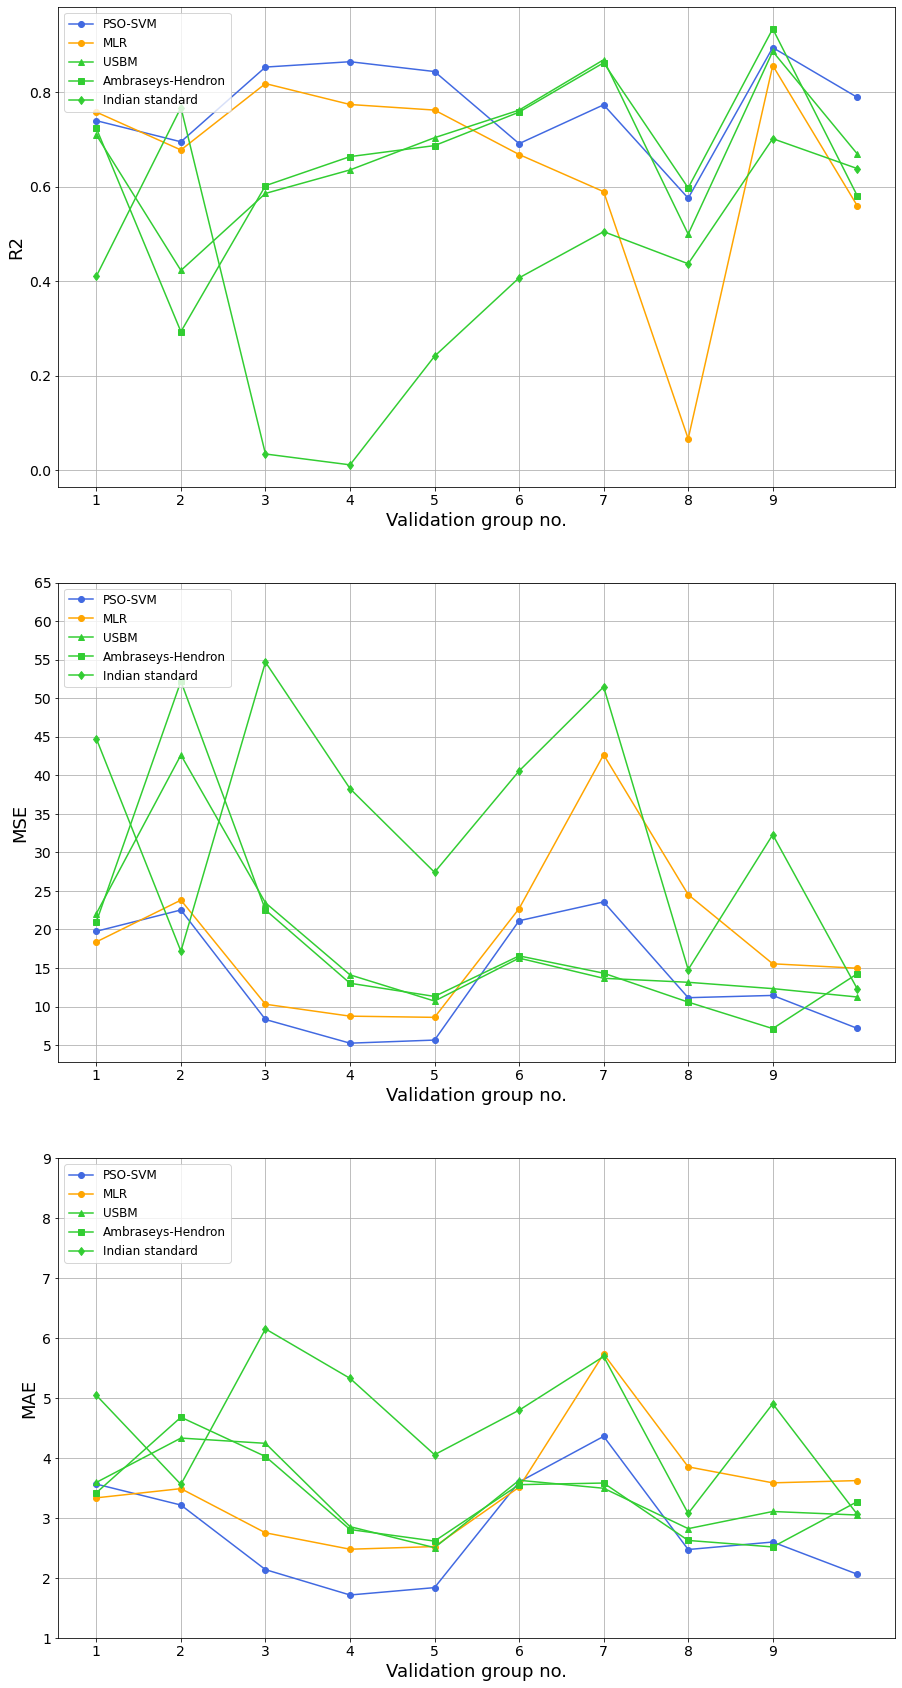

In [46]:
validation_compare_plot(feature_transformed, targets)

# Scatter Plot

In [47]:
def Loocv_scatter_plot (feature_transformed, new_targets_tmp, 
                C = 0.1 , epsilon = 0.1, gamma = 0.1, 
                SVM = False, MLR = False):

  """
  This function is to plot the scatter plots of MLR or PSO-SVM model.

  Parameters
  ----------
  feature_transformed: pandas.DataFrame
                      The features
  new_targets_tmp    : pandas.DataFrame
                      The targets
  C                  : float (default 0.1)
                      The C hyperparameter of SVM 
  epsilon            : float (default 0.1)
                      The epsilon hyperparameter of SVM 
  gamma              : float (default 0.1)
                      The gamma hyperparameter of SVM 
  SVM                : bool (default False)
                      The option of plotting the scatter of SVM
  
  MLR                : bool (default False)
                      The option of plotting the scatter of MLR

  Returns
  -------
  No returns as it directly save a set of figures
  """

  R2_list = []
  total_targets = np.array([])
  total_predicted_targets = np.array([])
  loo = KFold(n_splits=10)

  fig= plt.figure(figsize=(20,20))
  ax = fig.add_subplot(111)
  i = 0

  if (SVM):
    model= SVR(kernel='rbf',C=C,epsilon=epsilon ,gamma=gamma)
    R2_tmp = 0.7716
    pic_path = 'Pics/PSO-SVM_True_vs_Pred'
  elif (MLR):
    model = LinearRegression()
    R2_tmp = 0.5788
    pic_path = 'Pics/MLR_True_vs_Pred'

  for train, test in loo.split(feature_transformed):

    X_train = np.array(feature_transformed[train])
    y_train = np.array(new_targets_tmp)[train]
    X_test =  np.array(feature_transformed[test])
    y_test = np.array(new_targets_tmp)[test]
    total_targets = np.append(total_targets, y_test)
    
    model.fit(X_train,y_train)
    predict_results = model.predict(X_test)
    total_predicted_targets = np.append(total_predicted_targets,predict_results)
    R2_list.append(metrics.r2_score(predict_results, y_test))

    ax.scatter( y_test, predict_results, label = str(i+1)+'th validatoin group', s=500)
    ax.set_xlabel("Measured value",fontsize = 28)
    ax.set_ylabel("Predicted value", fontsize = 28)
    i = i + 1

  x = np.linspace(*ax.get_xlim())
  ax.plot(x, x, "black", label = 'y = x')
  ax.text(0.4, 0.8, "R2 = "+str(R2_tmp), transform=ax.transAxes, size = 40)
  ax.legend(prop = {'size':18})
  ax.grid()
  plt.show()
  fig.savefig(pic_path)


  return total_targets, total_predicted_targets
  

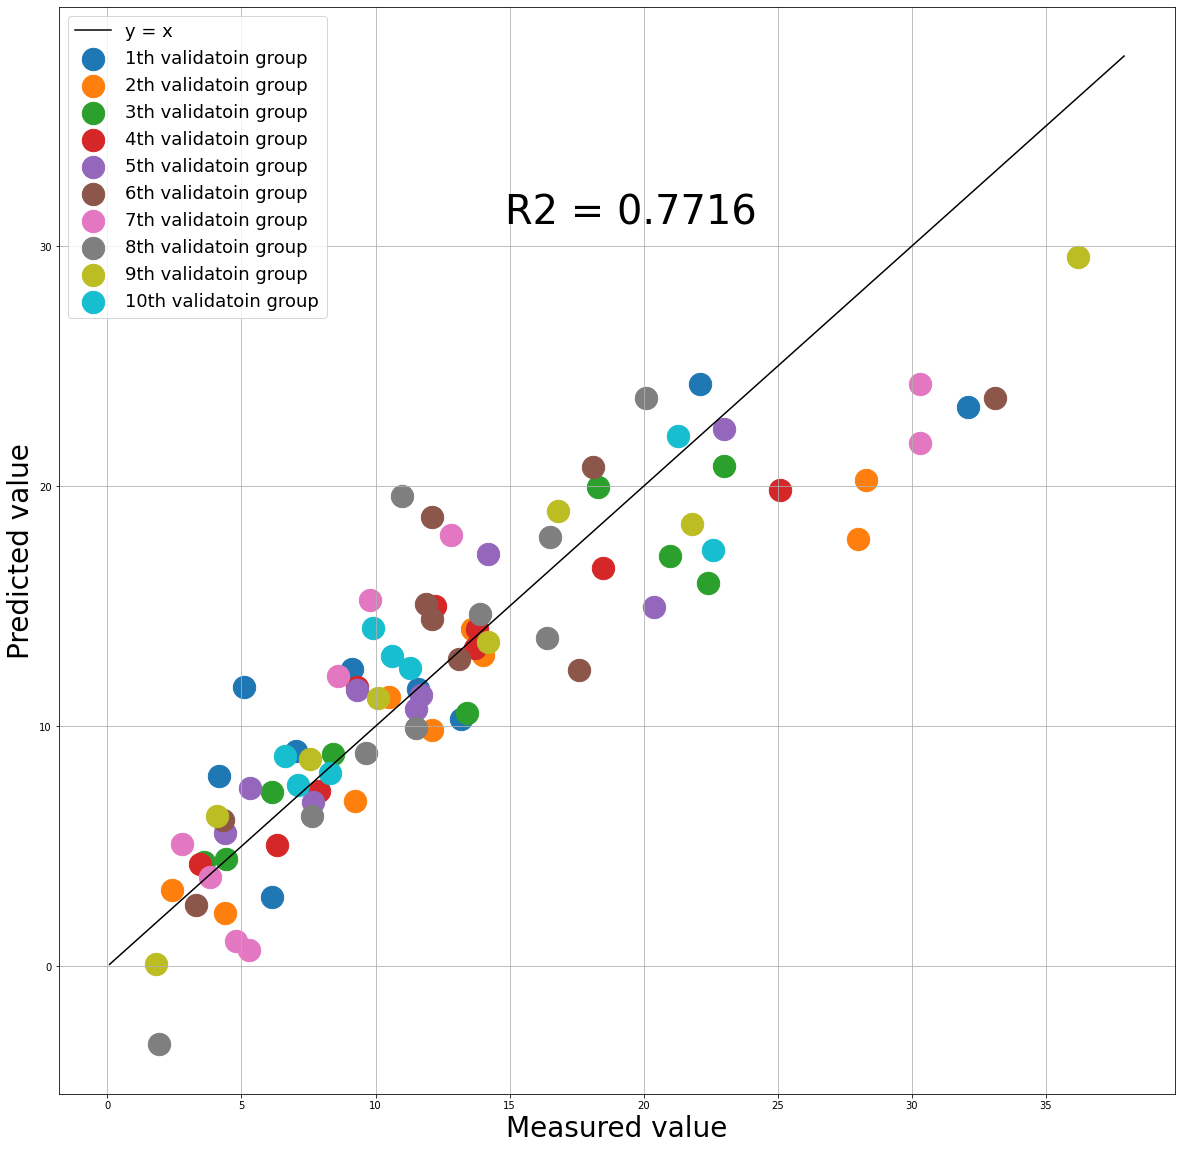

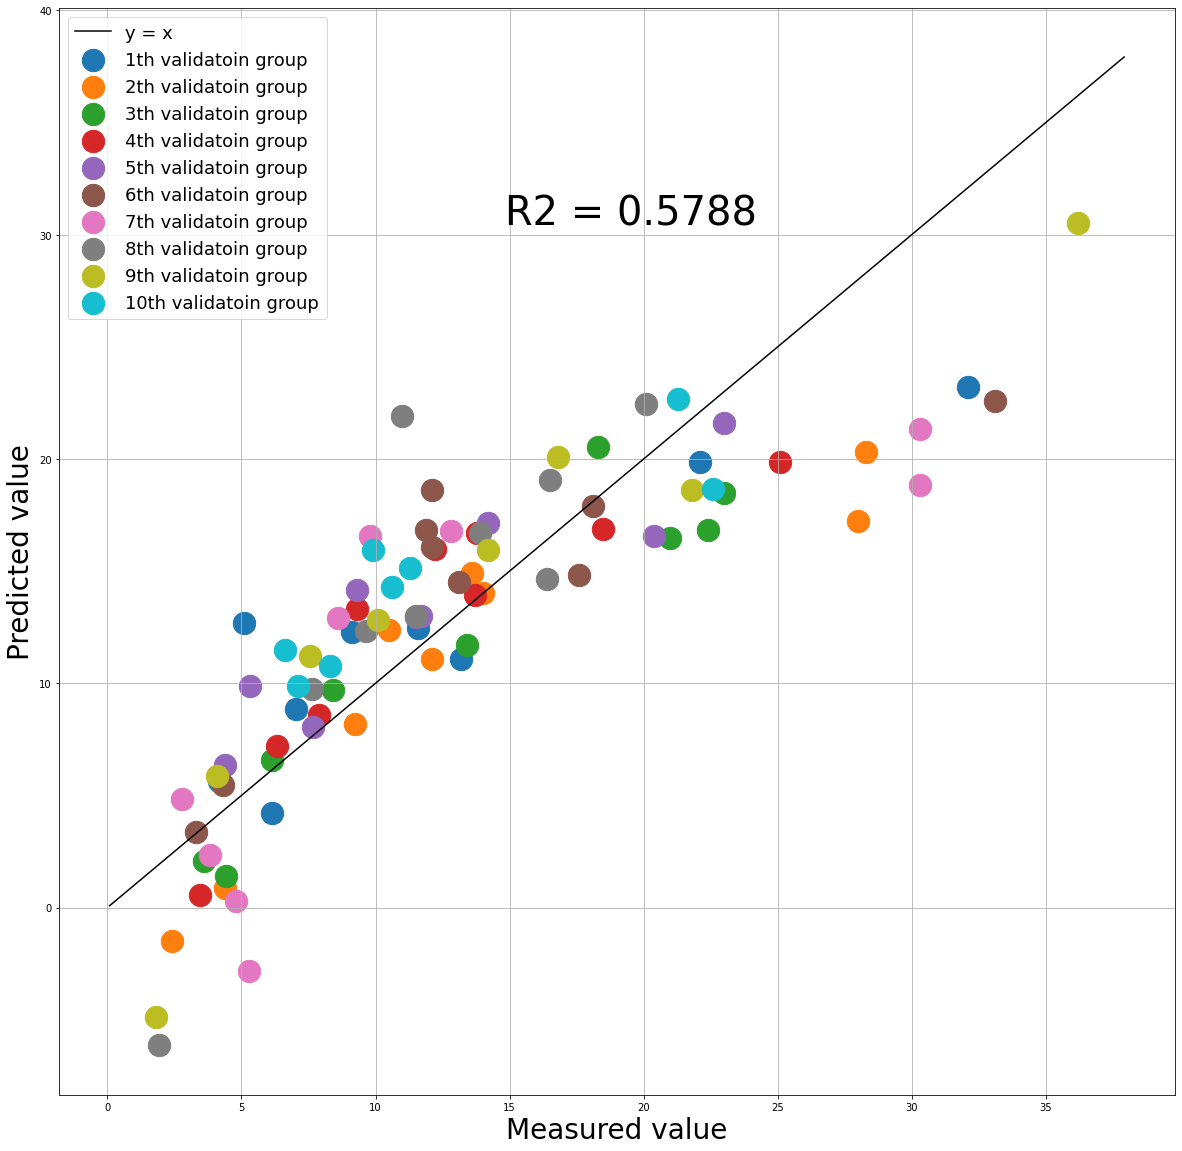

In [48]:
total_targets, total_predicted_targets = Loocv_scatter_plot(feature_transformed, targets, C=268.277249,epsilon=0.001 ,gamma=0.140431318, SVM = True)
total_targets, total_predicted_targets = Loocv_scatter_plot(feature_transformed, targets, MLR = True)


In [ ]:
def Loocv_scatter_EM (feature_transformed, targets):
  """
  This function is to plot the scatter plots of empirical models.

  Parameters
  ----------
  feature_transformed: pandas.DataFrame
                      The features
  targets            : pandas.DataFrame
                      The targets

  Returns
  -------
  No returns as it directly save a set of figures
  """

  loo = KFold(n_splits=10)
  i = 0

  fig= plt.figure(figsize=(40,13))
  ax1 = fig.add_subplot(131)
  ax2 = fig.add_subplot(132)
  ax3 = fig.add_subplot(133)

  for train, test in loo.split(feature_transformed):

    D = np.array(em_blast_data.iloc[1:, 8]).ravel()
    Q = np.array(em_blast_data.iloc[1:, 7]).ravel()
    D = D[test]
    Q = Q[test]
    y_test = np.array(targets)[test]
    
    y_EM1 = 248.370 * np.power(D/np.power(Q,0.5),-1.207)
    y_EM2 = 676.242 * np.power(D/np.power(Q,0.33),-1.215)
    y_EM3 = 1.911 * np.power(Q/np.power(D,2/3),1.219)

    ax1.scatter( y_test, y_EM1, label = str(i+1)+'th validatoin group', s=500 )
    ax1.set_xlabel("Measured value",fontsize = 28)
    ax1.set_ylabel("Predicted value", fontsize = 28)

    ax2.scatter( y_test, y_EM2, label = str(i+1)+'th validatoin group',s=500)
    ax2.set_xlabel("Measured value",fontsize = 28)
    ax2.set_ylabel("Predicted value", fontsize = 28)

    ax3.scatter( y_test, y_EM3, label = str(i+1)+'th validatoin group',s=500)
    ax3.set_xlabel("Measured value",fontsize = 28)
    ax3.set_ylabel("Predicted value", fontsize = 28)
    i = i + 1

  x = np.linspace(*ax1.get_xlim())
  ax1.plot(x, x, "black", label = 'y = x')
  ax1.text(0.5, 0.8, "R2 = "+str(0.7111), transform=ax1.transAxes, fontsize = 28)
  # ax1.legend()
  ax1.grid()

  ax2.plot(x, x, "black", label = 'y = x')
  ax2.text(0.5, 0.8, "R2 = "+str(0.7052), transform=ax2.transAxes, fontsize = 28)

  ax2.grid()

  ax3.plot(x, x, "black", label = 'y = x')
  ax3.text(0.5, 0.8, "R2 = "+str(0.4634), transform=ax3.transAxes, fontsize = 28)

  ax3.grid()

  fig.savefig("Pics/Empirical_Measure_vs_Pred")
  plt.show()

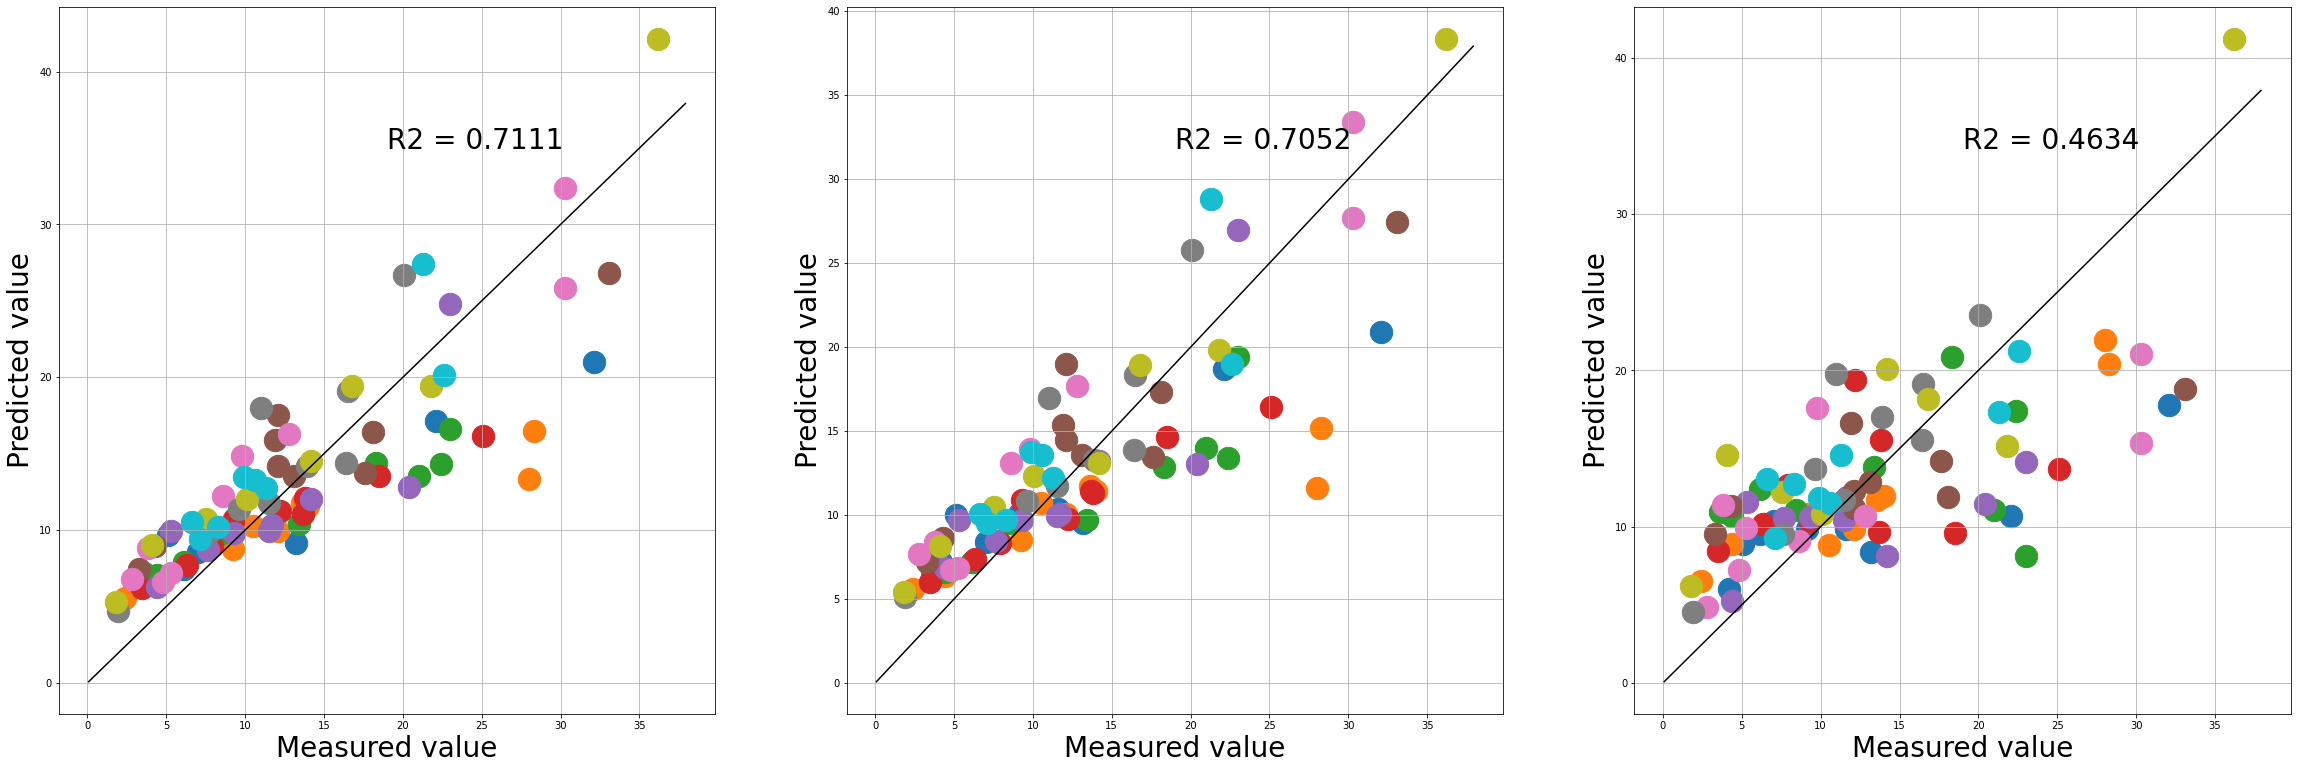

In [ ]:
Loocv_scatter_EM (feature_transformed, targets)